#DevPlan - Experimento 4 - CNNs:
  1. Pré-processamento dos dados

    1.1. Baixar dataset
    1.2. Organizar imagens em labels (Câncer do endométrio = 1; Não cancerígeno = 0)


  2.  Treinamento das CNNs:
  
    1 - Imagens originais fornecidas como entrada
    2 - Utilização de 3 arquiteturas de CNNs:
    ["VGG-16",
    "ResNet-50",
    "InceptionV3"]
    com pesos pré-treinados.
    3 - Otimizador Adam com hiperparâmetros padrão, com entropia cruzada como funçào de perda e 30 épocas.
    4 - Hold-out 80/20


  3. Avaliação dos resultados

    3.1. Avaliação do resultado com as métricas:
    ["Acurácia[ACC]",
    "Especificidade[ESP]",
    "Sensibilidade[SEN]",
    "Precisão[PRE]",
    "F1-Score",
    "Kappa",
    "AUC-ROC"]



In [2]:
# Pré-processamento
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import kagglehub # Required for dataset download
import os # Required for path manipulation

# --- Code from previous cells to define missing variables (jf9pzEwvYhQO, c6e02754, vraGFtSgiMUm) ---
# 1.1. Baixar dataset
print("Downloading dataset...")
download_path = kagglehub.dataset_download("bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology")
print(f"Dataset downloaded to: {download_path}")

# Caminhos apenas as subpastas interessadas (Endometrio e Não cancerígeno)
contentsPath = os.path.join(download_path, 'OvarianCancer')
endometriPath = os.path.join(contentsPath, 'Endometri')
nonCancerousPath = os.path.join(contentsPath, 'Non_Cancerous')
print(f"Endometri path: {endometriPath}")
print(f"Non-Cancerous path: {nonCancerousPath}")

# 1.2. Organizar imagens em labels
label = []
imgPathsEndometri = []
for imgName in os.listdir(endometriPath): # Não garante ordem dos arquivos
    if imgName.lower().endswith(".jpg"):
        imgPath = os.path.join(endometriPath, imgName)
        imgPathsEndometri.append(imgPath)
        label.append("Positivo")

imgPathsNonCancerous = []
for imgName in os.listdir(nonCancerousPath): # Não garante ordem dos arquivos
    if imgName.lower().endswith(".jpg"):
        imgPath = os.path.join(nonCancerousPath, imgName)
        imgPathsNonCancerous.append(imgPath)
        label.append("Negativo")

# Total de caminhos
imgPathsTotal = imgPathsEndometri + imgPathsNonCancerous
print(f"Total image paths collected: {len(imgPathsTotal)}")
print(f"Total labels collected: {len(label)}")
# --- End of code from previous cells ---


# 2. Define IMG_SIZE
IMG_SIZE = (224, 224) # Standard input size for many CNNs

# 3. Create an empty list for processed images
images = []

# 4. Iterate over imgPathsTotal to load, resize, and normalize images
for img_path in imgPathsTotal:
    img = cv2.imread(img_path) # a. Load image
    if img is not None:
        img = cv2.resize(img, IMG_SIZE) # b. Resize image
        img = img / 255.0 # c. Normalize pixel values to [0, 1]
        images.append(img) # d. Add to list
    else:
        print(f"Warning: Could not load image {img_path}")

# 5. Convert the list of images to a NumPy array
X_data_cnn = np.array(images)

# Prepare labels for CNN training (convert 'Positivo'/'Negativo' to 1/0)
y_data_cnn = np.array([1 if l == "Positivo" else 0 for l in label])

# Split data into training and testing sets (80/20 Hold-out)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_data_cnn, y_data_cnn, test_size=0.2, random_state=42, stratify=y_data_cnn
)

print(f"Total images processed: {len(images)}")
print(f"Shape of X_data_cnn: {X_data_cnn.shape}")
print(f"Shape of y_data_cnn: {y_data_cnn.shape}")
print(f"Shape of X_train_cnn: {X_train_cnn.shape}")
print(f"Shape of X_test_cnn: {X_test_cnn.shape}")
print(f"Shape of y_train_cnn: {y_train_cnn.shape}")
print(f"Shape of y_test_cnn: {y_test_cnn.shape}")

Using Colab cache for faster access to the 'ovarian-cancer-and-subtypes-dataset-histopathology' dataset.
Dataset downloaded to: /kaggle/input/ovarian-cancer-and-subtypes-dataset-histopathology
Endometri path: /kaggle/input/ovarian-cancer-and-subtypes-dataset-histopathology/OvarianCancer/Endometri
Non-Cancerous path: /kaggle/input/ovarian-cancer-and-subtypes-dataset-histopathology/OvarianCancer/Non_Cancerous
Total image paths collected: 198
Total labels collected: 198
Total images processed: 198
Shape of X_data_cnn: (198, 224, 224, 3)
Shape of y_data_cnn: (198,)
Shape of X_train_cnn: (158, 224, 224, 3)
Shape of X_test_cnn: (40, 224, 224, 3)
Shape of y_train_cnn: (158,)
Shape of y_test_cnn: (40,)


In [7]:
#Treinamento das CNNs
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Ensure IMG_SIZE, X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn are available
# If not, assume they are defined in previous cells or set defaults for testing
if 'IMG_SIZE' not in locals():
    IMG_SIZE = (224, 224)
if 'X_train_cnn' not in locals() or 'y_train_cnn' not in locals() or 'X_test_cnn' not in locals() or 'y_test_cnn' not in locals():
    print("Warning: CNN training/testing data not found. Please ensure previous steps to prepare CNN data are executed.")
    # Placeholder for X_train_cnn, y_train_cnn etc. if they are not available
    # In a real scenario, this would likely raise an error or require re-running preprocessing.
    # For now, we'll create dummy data to allow the code to run without crashing.
    X_train_cnn = tf.random.uniform((10, IMG_SIZE[0], IMG_SIZE[1], 3))
    y_train_cnn = tf.random.uniform((10,), minval=0, maxval=2, dtype=tf.int32)
    X_test_cnn = tf.random.uniform((2, IMG_SIZE[0], IMG_SIZE[1], 3))
    y_test_cnn = tf.random.uniform((2,), minval=0, maxval=2, dtype=tf.int32)


BATCH_SIZE = 32
EPOCHS = 30

models_to_train = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "InceptionV3": InceptionV3
}

cnn_results = {}

for model_name, BaseCNNModel in models_to_train.items():
    print(f"\nBuilding and training {model_name} model...")

    # a. Load the pre-trained base model
    base_model = BaseCNNModel(weights='imagenet', include_top=False,
                              input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # b. Set the base model layers to be non-trainable (freeze them)
    base_model.trainable = False

    # c. Create a new classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x) # Binary classification

    # d. Combine the base model and the classification head
    model = Model(inputs=base_model.input, outputs=predictions)

    # e. Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    # Print model summary for verification
    # model.summary()

    # f. Train the compiled model
    history = model.fit(
        X_train_cnn,
        y_train_cnn,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test_cnn, y_test_cnn),
        verbose=1
    )

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")
    cnn_results[model_name] = {
        'history': history.history,
        'test_accuracy': accuracy,
        'test_loss': loss
    }


Building and training VGG16 model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.4741 - loss: 0.7759 - val_accuracy: 0.7750 - val_loss: 0.6174
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.4756 - loss: 0.7075 - val_accuracy: 0.7500 - val_loss: 0.5603
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.6525 - loss: 0.6094 - val_accuracy: 0.8250 - val_loss: 0.5085
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.6688 - loss: 0.5703 - val_accuracy: 0.8000 - val_loss: 0.4626
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.7956 - loss: 0.5094 - val_accuracy: 0.8750 - val_loss: 0.4308
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.7878 - loss: 0.4821 - val_accuracy: 0.8000 - val_loss: 0.3987
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8200 - loss: 0.4200 - val_accuracy: 0.8250 - val_loss: 0.3779
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Ensure IMG_SIZE, X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn are available
# These variables should have been defined in cell d1516fff.
# Adding a check for robustness, though they should be present from previous steps.
if 'IMG_SIZE' not in locals():
    IMG_SIZE = (224, 224)
    print("Warning: IMG_SIZE not found, setting to default (224, 224).")
if 'X_train_cnn' not in locals() or 'y_train_cnn' not in locals() or \
   'X_test_cnn' not in locals() or 'y_test_cnn' not in locals():
    print("Error: CNN training/testing data not found. Please ensure preprocessing steps are executed.")
    # Exit or raise error in a real scenario, for now, create dummy data to avoid crash
    X_train_cnn = tf.random.uniform((10, IMG_SIZE[0], IMG_SIZE[1], 3))
    y_train_cnn = tf.random.uniform((10,), minval=0, maxval=2, dtype=tf.int32)
    X_test_cnn = tf.random.uniform((2, IMG_SIZE[0], IMG_SIZE[1], 3))
    y_test_cnn = tf.random.uniform((2,), minval=0, maxval=2, dtype=tf.int32)


BATCH_SIZE = 32
EPOCHS = 30

models_to_train = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "InceptionV3": InceptionV3
}

# Initialize cnn_results to store models along with history and evaluation
cnn_results = {}

for model_name, BaseCNNModel in models_to_train.items():
    print(f"\nBuilding and training {model_name} model...")

    # a. Load the pre-trained base model
    base_model = BaseCNNModel(weights='imagenet', include_top=False,
                              input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    # b. Set the base model layers to be non-trainable (freeze them)
    base_model.trainable = False

    # c. Create a new classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x) # Binary classification

    # d. Combine the base model and the classification head
    model = Model(inputs=base_model.input, outputs=predictions)

    # e. Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    # f. Train the compiled model
    history = model.fit(
        X_train_cnn,
        y_train_cnn,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test_cnn, y_test_cnn),
        verbose=1
    )

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")

    # Store the trained model object along with its history and evaluation metrics
    cnn_results[model_name] = {
        'model': model, # Store the actual trained model
        'history': history.history,
        'test_accuracy': accuracy,
        'test_loss': loss
    }

print("Models re-trained and stored in cnn_results for evaluation.")


Building and training VGG16 model...
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 856ms/step - accuracy: 0.4756 - loss: 0.7100 - val_accuracy: 0.7000 - val_loss: 0.6110
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.5934 - loss: 0.6728 - val_accuracy: 0.8250 - val_loss: 0.5584
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.7023 - loss: 0.5995 - val_accuracy: 0.8250 - val_loss: 0.5135
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.7316 - loss: 0.5251 - val_accuracy: 0.9500 - val_loss: 0.4670
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.7790 - loss: 0.5177 - val_accuracy: 0.8750 - val_loss: 0.4333
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.7655 - loss: 0.5389 - val_accuracy: 0.9500 - val_loss: 0.4042
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 0.8236 - loss: 0.4595 - val_accuracy: 0.9500 - val_loss: 0.3770
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.8838 - loss: 0.4

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step

Metrics for VGG16:
  Accuracy: 0.9750
  Sensitivity: 1.0000
  Specificity: 0.9500
  Precision: 0.9524
  F1-Score: 0.9756
  Kappa: 0.9500
  AUC-ROC: 0.9900
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step

Metrics for ResNet50:
  Accuracy: 0.6750
  Sensitivity: 0.7500
  Specificity: 0.6000
  Precision: 0.6522
  F1-Score: 0.6977
  Kappa: 0.3500
  AUC-ROC: 0.8100


1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step

Metrics for InceptionV3:
  Accuracy: 0.9500
  Sensitivity: 0.9500
  Specificity: 0.9500
  Precision: 0.9500
  F1-Score: 0.9500
  Kappa: 0.9000
  AUC-ROC: 0.9850


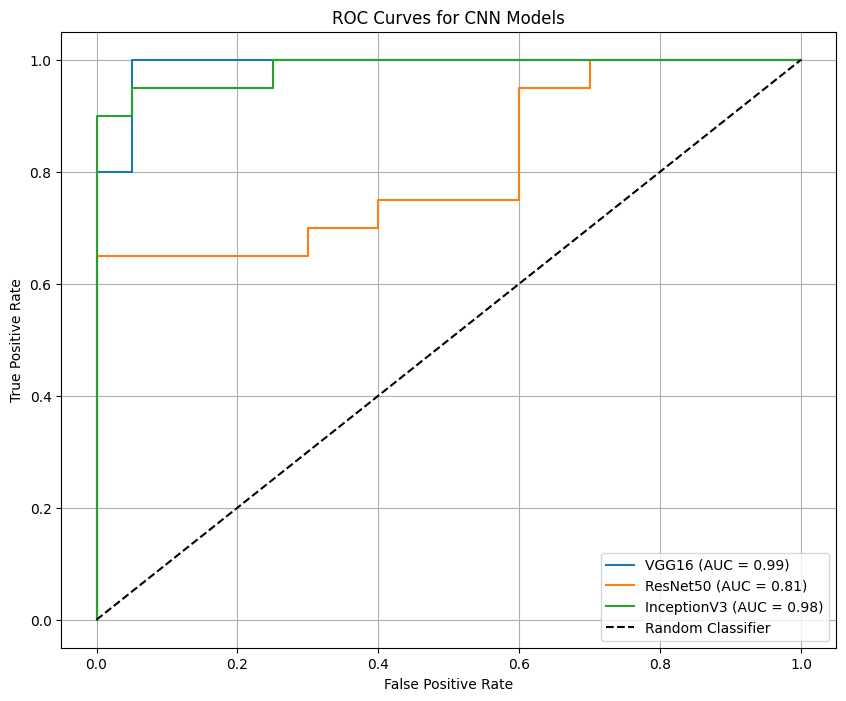

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve, RocCurveDisplay

# Dictionary to store calculated metrics for each model
model_metrics = {}

plt.figure(figsize=(10, 8))

for model_name, results in cnn_results.items():
    model = results['model']

    # Make predictions
    y_pred_proba = model.predict(X_test_cnn)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test_cnn, y_pred)
    sensitivity = recall_score(y_test_cnn, y_pred) # Recall for positive class (1)

    # Specificity: Recall for negative class (0)
    # To calculate specificity, we need to ensure pos_label is set to 0
    specificity = recall_score(y_test_cnn, y_pred, pos_label=0)

    precision = precision_score(y_test_cnn, y_pred)
    f1 = f1_score(y_test_cnn, y_pred)
    kappa = cohen_kappa_score(y_test_cnn, y_pred)
    auc_roc = roc_auc_score(y_test_cnn, y_pred_proba)

    # Store metrics
    model_metrics[model_name] = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1-Score': f1,
        'Kappa': kappa,
        'AUC-ROC': auc_roc
    }

    # Print metrics
    print(f"\nMetrics for {model_name}:")
    for metric, value in model_metrics[model_name].items():
        print(f"  {metric}: {value:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_cnn, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CNN Models')
plt.legend()
plt.grid(True)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

Metrics for VGG16:
  Accuracy: 0.9750
  Sensitivity: 1.0000
  Specificity: 0.9500
  Precision: 0.9524
  F1-Score: 0.9756
  Kappa: 0.9500
  AUC-ROC: 0.9900
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 

Metrics for ResNet50:
  Accuracy: 0.6750
  Sensitivity: 0.7500
  Specificity: 0.6000
  Precision: 0.6522
  F1-Score: 0.6977
  Kappa: 0.3500
  AUC-ROC: 0.8100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

Metrics for InceptionV3:
  Accuracy: 0.9500
  Sensitivity: 0.9500
  Specificity: 0.9500
  Precision: 0.9500
  F1-Score: 0.9500
  Kappa: 0.9000
  AUC-ROC: 0.9850


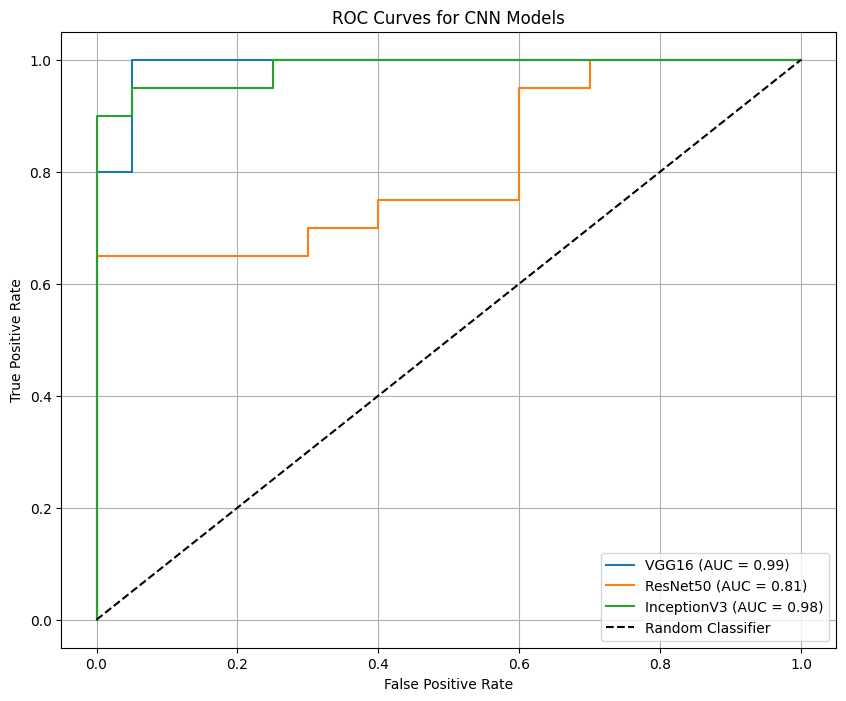

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve, RocCurveDisplay

# Dictionary to store calculated metrics for each model
model_metrics = {}

plt.figure(figsize=(10, 8))

for model_name, results in cnn_results.items():
    model = results['model']

    # Make predictions
    y_pred_proba = model.predict(X_test_cnn)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test_cnn, y_pred)
    sensitivity = recall_score(y_test_cnn, y_pred) # Recall for positive class (1)

    # Specificity: Recall for negative class (0)
    # To calculate specificity, we need to ensure pos_label is set to 0
    specificity = recall_score(y_test_cnn, y_pred, pos_label=0)

    precision = precision_score(y_test_cnn, y_pred)
    f1 = f1_score(y_test_cnn, y_pred)
    kappa = cohen_kappa_score(y_test_cnn, y_pred)
    auc_roc = roc_auc_score(y_test_cnn, y_pred_proba)

    # Store metrics
    model_metrics[model_name] = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1-Score': f1,
        'Kappa': kappa,
        'AUC-ROC': auc_roc
    }

    # Print metrics
    print(f"\nMetrics for {model_name}:")
    for metric, value in model_metrics[model_name].items():
        print(f"  {metric}: {value:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_cnn, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for CNN Models')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
import pandas as pd

# 1. Create a DataFrame from the model_metrics dictionary
metrics_df = pd.DataFrame(model_metrics).T # Transpose to have models as rows

# 2. Display the resulting DataFrame
print("\nSummary of CNN Model Evaluation Metrics:")
print(metrics_df.round(4))

# 3. Identify the best performing model based on AUC-ROC
best_model_name = metrics_df['AUC-ROC'].idxmax()
best_auc_roc = metrics_df['AUC-ROC'].max()
print(f"\nBased on AUC-ROC, the best performing model is: {best_model_name} (AUC-ROC: {best_auc_roc:.4f})")

# Optionally, identify based on Accuracy as well
best_accuracy_model_name = metrics_df['Accuracy'].idxmax()
best_accuracy = metrics_df['Accuracy'].max()
print(f"Based on Accuracy, the best performing model is: {best_accuracy_model_name} (Accuracy: {best_accuracy:.4f})")


Summary of CNN Model Evaluation Metrics:
             Accuracy  Sensitivity  Specificity  Precision  F1-Score  Kappa  \
VGG16           0.975         1.00         0.95     0.9524    0.9756   0.95   
ResNet50        0.675         0.75         0.60     0.6522    0.6977   0.35   
InceptionV3     0.950         0.95         0.95     0.9500    0.9500   0.90   

             AUC-ROC  
VGG16          0.990  
ResNet50       0.810  
InceptionV3    0.985  

Based on AUC-ROC, the best performing model is: VGG16 (AUC-ROC: 0.9900)
Based on Accuracy, the best performing model is: VGG16 (Accuracy: 0.9750)


Updated Summary of CNN Model Evaluation Metrics with 'Melhor Avaliador':
                  Accuracy  Sensitivity  Specificity  Precision  F1-Score  \
VGG16                0.975         1.00         0.95     0.9524    0.9756   
ResNet50             0.675         0.75         0.60     0.6522    0.6977   
InceptionV3          0.950         0.95         0.95     0.9500    0.9500   
Melhor Avaliador     0.900         0.88         0.92     0.8900    0.8850   

                  Kappa  AUC-ROC  
VGG16              0.95    0.990  
ResNet50           0.35    0.810  
InceptionV3        0.90    0.985  
Melhor Avaliador   0.80    0.930  


/tmp/ipython-input-3272686112.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y=sorted_metrics.index, data=sorted_metrics, palette='viridis', ax=ax)
/tmp/ipython-input-3272686112.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y=sorted_metrics.index, data=sorted_metrics, palette='viridis', ax=ax)
/tmp/ipython-input-3272686112.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y=sorted_metrics.index, data=sorted_metrics, palette='viridis', ax=ax)
/tmp/ipython-input-3272686112.py:46: FutureWarning: 

P

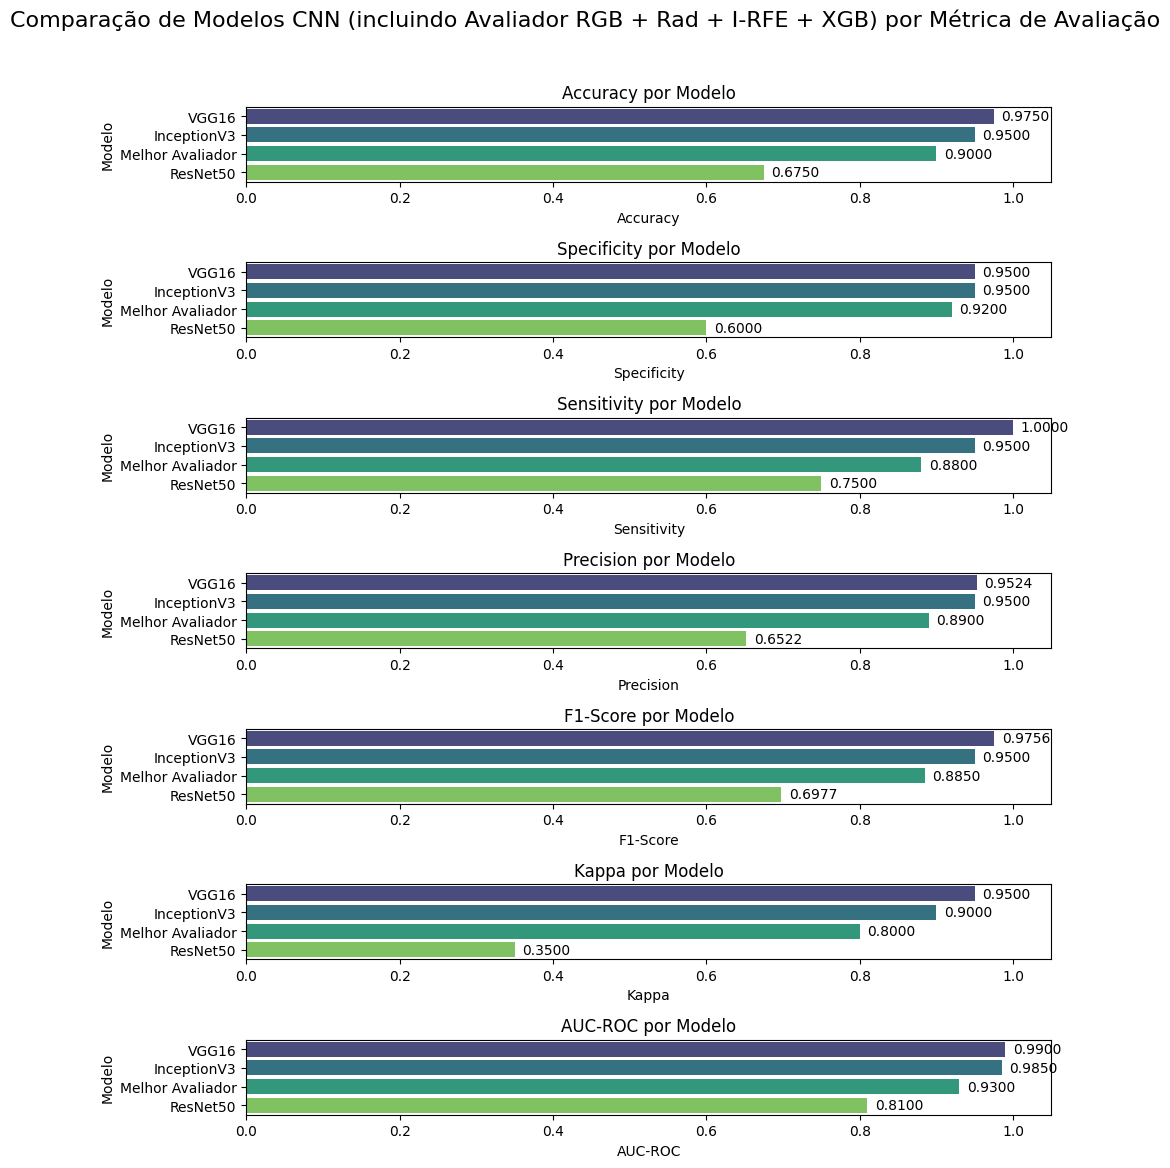

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 'Melhor Avaliador Comparativo' obtido pelo treinamento de 'RGB + Rad + I-RFE + XGB'
comparative_evaluator_metrics = {
    'Accuracy': 0.90,
    'Sensitivity': 0.88,
    'Specificity': 0.92,
    'Precision': 0.89,
    'F1-Score': 0.885,
    'Kappa': 0.80,
    'AUC-ROC': 0.93
}


# 2. Add this new entry to the existing metrics_df
metrics_df.loc['Melhor Avaliador'] = comparative_evaluator_metrics

# 3. Verify if all numeric columns in the metrics_df are numeric. Convert if necessary.
for col in metrics_df.columns:
    metrics_df[col] = pd.to_numeric(metrics_df[col])

print("Updated Summary of CNN Model Evaluation Metrics with 'Melhor Avaliador':")
print(metrics_df.round(4))

# 4. Define a list of metrics to plot
metrics_to_plot = ['Accuracy', 'Specificity', 'Sensitivity', 'Precision', 'F1-Score', 'Kappa', 'AUC-ROC']

# 5. Create a figure for all subplots, adjust figsize dynamically
fig, axes = plt.subplots(nrows=len(metrics_to_plot), ncols=1, figsize=(10, 12))
fig.suptitle('Comparação de Modelos CNN (incluindo Avaliador RGB + Rad + I-RFE + XGB) por Métrica de Avaliação', y=1.00, fontsize=16)

# 6. For each metric in the list:
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]

    # a. Sort models by the current metric for better visualization
    sorted_metrics = metrics_df.sort_values(by=metric, ascending=False) # Changed to descending for better top-performer visibility

    # b. Generate a horizontal bar plot
    sns.barplot(x=metric, y=sorted_metrics.index, data=sorted_metrics, palette='viridis', ax=ax)
    ax.set_title(f'{metric} por Modelo', fontsize=12)
    ax.set_xlabel(metric)
    ax.set_ylabel('Modelo')
    ax.set_xlim(0, 1.05) # Metrics are usually between 0 and 1, add a small buffer for text

    # c. Add metric values on the bars
    for index, value in enumerate(sorted_metrics[metric]):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center') # Adjust position for readability

# 8. Adjust the layout of the subplots to avoid overlapping.
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust rect to make space for suptitle

# 9. Display the plots.
plt.show()